In [37]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

## Data

In [38]:
min_non_zero_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [39]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [40]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E012854' 'E010481' 'E001958']


In [41]:
print(len(train_feats), len(train_targets))

263 263


In [42]:
train_targets = np.asarray(train_targets)
train_targets = pd.DataFrame(train_targets)
train_targets.columns = df.columns[~df.columns.isin(metadata_cols)]

In [43]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.203697,0.000080,0.311111,0.086282,0.145710,0.189320,0.076923,0.023810,0.000000,0.087248,...,0.000000,0.214286,0.000000,0.088235,0.000000,0.242881,0.139241,0.151929,0.162053,0.083744
1,0.127876,0.000120,0.000000,0.019243,0.000000,0.000000,0.020513,0.047619,0.005800,0.154362,...,0.000000,0.000000,0.002480,0.205882,0.000028,0.003769,0.000000,0.001038,0.000281,0.093596
2,0.034704,0.000120,0.000000,0.072005,0.020710,0.179612,0.002564,0.404762,0.053907,0.281879,...,0.106651,0.008929,0.000533,0.411765,0.029421,0.004397,0.000000,0.047240,0.000125,0.054187
3,0.050170,0.000140,0.155556,0.027312,0.000740,0.092233,0.233333,0.071429,0.072671,0.275168,...,0.618119,0.062500,0.000080,0.029412,0.000937,0.219430,0.075949,0.202976,0.222913,0.428571
4,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.557339,0.107143,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.031309,0.000280,0.133333,0.043451,0.063609,0.111650,0.128205,0.023810,0.000000,0.006711,...,0.110092,0.017857,0.000213,0.029412,0.003947,0.409338,0.120253,0.133068,0.100662,0.236453
259,0.000377,0.100947,0.111111,0.005587,0.058432,0.082524,0.005128,0.261905,0.268509,0.154362,...,0.137615,0.035714,0.003894,0.058824,0.009741,0.024916,0.044304,0.033224,0.033992,0.482759
260,0.066013,0.000881,0.155556,0.000000,0.044379,0.199029,0.076923,0.214286,0.025930,0.255034,...,0.034404,0.026786,0.001040,0.176471,0.000795,0.111809,0.012658,0.175463,0.146307,0.256158
261,0.013957,0.013412,0.422222,0.018001,0.117604,0.063107,0.553846,0.333333,0.011600,0.053691,...,0.263761,0.089286,0.022590,0.176471,0.031693,0.484506,0.069620,0.229278,0.246032,0.290640


## The model

In [44]:
def fetch_model(seq_length):

    reg = 1e-12
    
    n_feats = len(train_feats[0][0])
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [45]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [46]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [47]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [48]:
target_taxa = 364179

plot=False

if plot is True:
    plot_a_taxa_sequence(train_targets[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [49]:
n_epochs = 15

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)

model = fetch_model(seq_length=sequence_length)
model = compile_model(model, loss)

model.fit(x=train_feats, y=train_targets[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15
8/8 [==============================] - 2s 40ms/step - loss: nan - mae: 0.0296 - mape: 293944.4688 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 2/15
8/8 [==============================] - 0s 18ms/step - loss: 10.3730 - mae: 0.0258 - mape: 93.1727 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 3/15
8/8 [==============================] - 0s 17ms/step - loss: nan - mae: 0.0258 - mape: 93.1727 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 4/15
8/8 [==============================] - 0s 18ms/step - loss: 8.7699 - mae: 0.0258 - mape: 93.1727 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 5/15
8/8 [==============================] - 0s 17ms/step - loss: nan - mae: 0.0258 - mape: 93.1727 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 6/15
8/8 [==============================] - 0s 17ms/step - loss: 7.6400 - mae: 0.0258 - mape: 93.1727 - val_loss: nan - val_mae: 0.0221 - val_mape: 100.0000
Epoch 7/15
8/8 [==========

In [50]:
test_subjects

array(['E012854', 'E010481', 'E001958'], dtype=object)

In [51]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets = pd.concat(test_targets[target_subject]).T
test_subject_targets.columns = df.columns[:-1]

1/1 [==============================] - 0s 100ms/step


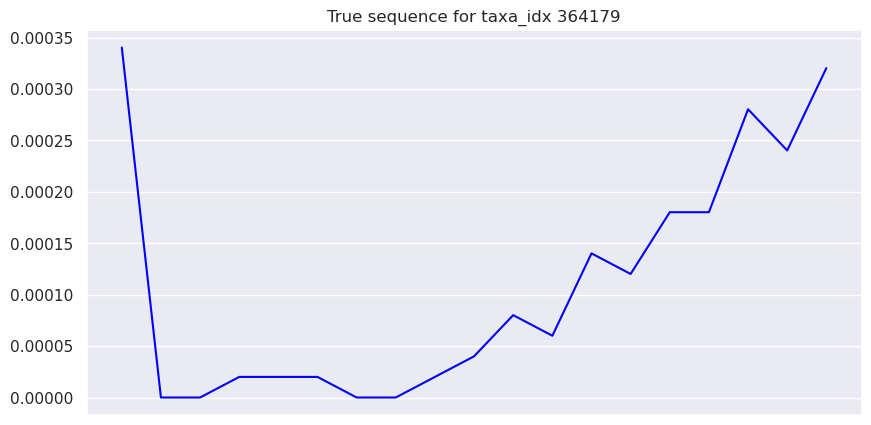

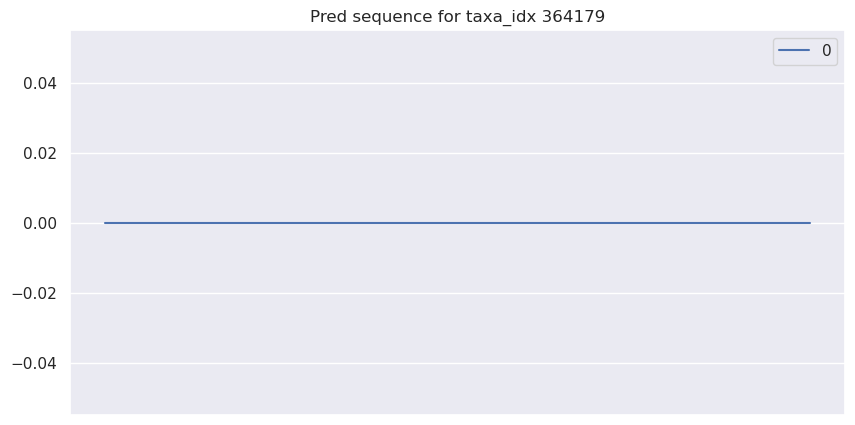

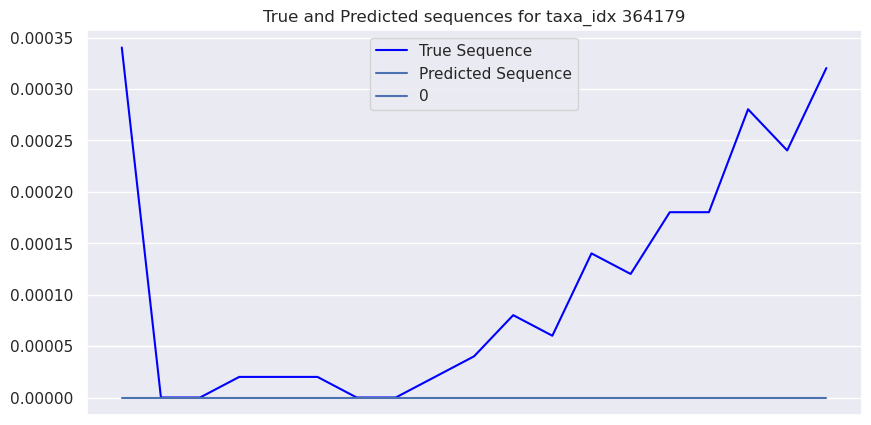

In [52]:
y_pred = model.predict(test_subject_feats)

true_sequence = test_subject_targets[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [53]:
class ensemble():

    def __init__(self, ensemble_name, loss, seq_length, overwrite_on_train=False):

        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss
        self.seq_length = seq_length

    def train(self, X_sequences_train, y_targets_train, n_epochs):

        # hardcoded stuff
        ignore_cols = ["subject_id", "sampling_day", "ind_time"]

        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)

        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):

            if taxa_idx not in ignore_cols:
                model = fetch_model(seq_length=self.seq_length)
                model = compile_model(model, loss)
                y_targets = y_targets_train[taxa_idx]
                model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)

                model.save(f"{self.models_out_dir}/{taxa_idx}.model")

                del model

    def load(self):

        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))

            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")

            self.model_dic[taxa_idx] = model

    def predict(self, X_sequences):

        if not hasattr(self, "model_dic"):
            self.load()

        n_sequences = len(X_sequences)

        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences, ))
            del (model)

        pred_df = pd.DataFrame(pred_list).T

        return pred_df


In [54]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#loss = mae_ignore_zeros(false_positives_penalty_factor=1)
loss = "mae"

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True, seq_length=sequence_length)

In [55]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.203697,0.000080,0.311111,0.086282,0.145710,0.189320,0.076923,0.023810,0.000000,0.087248,...,0.000000,0.214286,0.000000,0.088235,0.000000,0.242881,0.139241,0.151929,0.162053,0.083744
1,0.127876,0.000120,0.000000,0.019243,0.000000,0.000000,0.020513,0.047619,0.005800,0.154362,...,0.000000,0.000000,0.002480,0.205882,0.000028,0.003769,0.000000,0.001038,0.000281,0.093596
2,0.034704,0.000120,0.000000,0.072005,0.020710,0.179612,0.002564,0.404762,0.053907,0.281879,...,0.106651,0.008929,0.000533,0.411765,0.029421,0.004397,0.000000,0.047240,0.000125,0.054187
3,0.050170,0.000140,0.155556,0.027312,0.000740,0.092233,0.233333,0.071429,0.072671,0.275168,...,0.618119,0.062500,0.000080,0.029412,0.000937,0.219430,0.075949,0.202976,0.222913,0.428571
4,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.557339,0.107143,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.031309,0.000280,0.133333,0.043451,0.063609,0.111650,0.128205,0.023810,0.000000,0.006711,...,0.110092,0.017857,0.000213,0.029412,0.003947,0.409338,0.120253,0.133068,0.100662,0.236453
259,0.000377,0.100947,0.111111,0.005587,0.058432,0.082524,0.005128,0.261905,0.268509,0.154362,...,0.137615,0.035714,0.003894,0.058824,0.009741,0.024916,0.044304,0.033224,0.033992,0.482759
260,0.066013,0.000881,0.155556,0.000000,0.044379,0.199029,0.076923,0.214286,0.025930,0.255034,...,0.034404,0.026786,0.001040,0.176471,0.000795,0.111809,0.012658,0.175463,0.146307,0.256158
261,0.013957,0.013412,0.422222,0.018001,0.117604,0.063107,0.553846,0.333333,0.011600,0.053691,...,0.263761,0.089286,0.022590,0.176471,0.031693,0.484506,0.069620,0.229278,0.246032,0.290640


In [56]:
model_ensemble.train(X_sequences_train=train_feats, y_targets_train=train_targets, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [19:15<00:00,  5.72s/it]


WThe ## Validation

In [57]:
test_subjects

array(['E012854', 'E010481', 'E001958'], dtype=object)

In [58]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

target_subject_y_test_df = pd.concat(test_targets[target_subject], axis=1).T
target_subject_y_test_df.columns = df.columns[:-1]

target_subject_y_test_df = target_subject_y_test_df.reset_index(drop=True).drop(columns=["subject_id", "sampling_day"])
target_subject_y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.082988,0.000340,0.133333,0.049038,0.161243,0.004854,0.000000,0.047619,0.025247,0.140940,...,0.025229,0.008929,0.015042,0.000000,0.000596,0.002303,0.000000,0.034435,0.120439,0.157635
1,0.043757,0.000000,0.177778,0.004966,0.000000,0.033981,0.002564,0.047619,0.027977,0.134228,...,0.030963,0.008929,0.000053,0.000000,0.000085,0.005863,0.044304,0.049836,0.254155,0.157635
2,0.013580,0.000000,0.244444,0.003104,0.000000,0.033981,0.002564,0.023810,0.018083,0.194631,...,0.022936,0.044643,0.020617,0.058824,0.000028,0.007328,0.056962,0.079599,0.343195,0.192118
3,0.004527,0.000020,0.311111,0.011173,0.000000,0.063107,0.002564,0.119048,0.075401,0.161074,...,0.047018,0.062500,0.020643,0.058824,0.000028,0.009213,0.063291,0.073542,0.541427,0.103448
4,0.003018,0.000020,0.333333,0.010552,0.000000,0.048544,0.000000,0.190476,0.115660,0.248322,...,0.114679,0.071429,0.020617,0.088235,0.000057,0.008794,0.031646,0.068005,0.576106,0.108374
5,0.001886,0.000020,0.511111,0.018622,0.000000,0.165049,0.000000,0.380952,0.227909,0.194631,...,0.241972,0.080357,0.000053,0.294118,0.000057,0.019054,0.082278,0.053816,0.735191,0.029557
6,0.000000,0.000000,0.444444,0.014277,0.000000,0.155340,0.000000,0.595238,0.310133,0.281879,...,0.283257,0.089286,0.000027,0.441176,0.000511,0.022822,0.164557,0.047759,0.701293,0.024631
7,0.000000,0.000000,0.422222,0.048417,0.000000,0.184466,0.002564,0.547619,0.265097,0.241611,...,0.230505,0.098214,0.000027,0.411765,0.000511,0.022404,0.170886,0.049663,0.701262,0.019704
8,0.000377,0.000020,0.400000,0.051521,0.000000,0.072816,0.005128,0.428571,0.161037,0.322148,...,0.183486,0.062500,0.000000,0.147059,0.001022,0.020101,0.132911,0.142412,0.779836,0.034483
9,0.000377,0.000040,0.355556,0.054004,0.001479,0.048544,0.005128,0.095238,0.061754,0.221477,...,0.185780,0.026786,0.000027,0.029412,0.001108,0.014028,0.082278,0.137740,0.601037,0.192118


In [59]:
target_subject_feats = np.asarray(test_feats[target_subject])
target_subject_y_pred_df = model_ensemble.predict(target_subject_feats)

Predicting values: 100%|██████████| 202/202 [00:29<00:00,  6.82it/s]


In [60]:
target_subject_y_pred_df = target_subject_y_pred_df.reset_index(drop=True)
target_subject_y_pred_df.columns = target_subject_y_test_df.columns
target_subject_y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003863,0.009277,0.095855,0.000000,0.116044,...,0.017393,0.000000,0.000000,0.158925,0.000000,0.017347,0.000000,0.000000,0.017082,0.079024
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.004585,0.008177,0.127444,0.000000,0.145270,...,0.023628,0.000000,0.000000,0.143431,0.000000,0.013389,0.000000,0.000000,0.011767,0.056319
2,0.000000,0.000000,0.004571,0.000000,0.000000,0.006150,0.008302,0.139747,0.000000,0.164806,...,0.048096,0.000000,0.000000,0.124225,0.000000,0.011712,0.000000,0.000000,0.006336,0.047723
3,0.000000,0.000000,0.024832,0.000000,0.000000,0.008038,0.008912,0.168310,0.000000,0.197190,...,0.098864,0.000000,0.000000,0.136724,0.000000,0.011525,0.000000,0.000000,0.001149,0.049749
4,0.000000,0.000000,0.093047,0.000000,0.000000,0.020230,0.011817,0.210602,0.000000,0.226668,...,0.179921,0.000000,0.000000,0.167112,0.000000,0.014868,0.000000,0.000000,0.000596,0.060874
5,0.000000,0.000000,0.176847,0.000000,0.000000,0.054984,0.019360,0.269167,0.000000,0.270254,...,0.278318,0.000000,0.000000,0.216875,0.000000,0.022723,0.000000,0.000000,0.005972,0.095848
6,0.000000,0.000000,0.298495,0.000000,0.000000,0.095461,0.043082,0.333666,0.000000,0.320792,...,0.373584,0.011348,0.000000,0.260014,0.000000,0.053784,0.000000,0.000000,0.026350,0.145255
7,0.000000,0.000000,0.354698,0.000000,0.000000,0.129660,0.064272,0.363573,0.000000,0.354728,...,0.413846,0.058800,0.000000,0.282378,0.000000,0.092399,0.000000,0.000000,0.150912,0.186408
8,0.000000,0.000000,0.360029,0.000000,0.000000,0.152292,0.077591,0.319501,0.000000,0.344586,...,0.389144,0.079368,0.000000,0.263621,0.000000,0.111376,0.000000,0.000000,0.249461,0.207605
9,0.000000,0.000000,0.345331,0.000000,0.000000,0.156387,0.097387,0.272427,0.000000,0.326931,...,0.368166,0.082180,0.000000,0.253859,0.000000,0.130830,0.000000,0.000000,0.314061,0.196886


In [61]:
non_predicted_taxa = [col for col in target_subject_y_pred_df.columns if all(target_subject_y_pred_df[col] == 0.0)]
n_non_predicted_taxa = len(non_predicted_taxa)

print(f"Total taxa not predicted: {len(non_predicted_taxa)}, {(n_non_predicted_taxa/len(target_subject_y_pred_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 96, 47.524752475247524% of all taxa


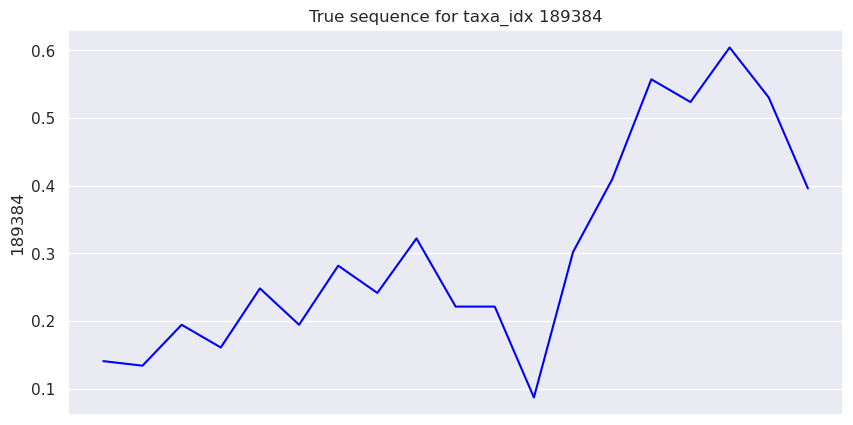

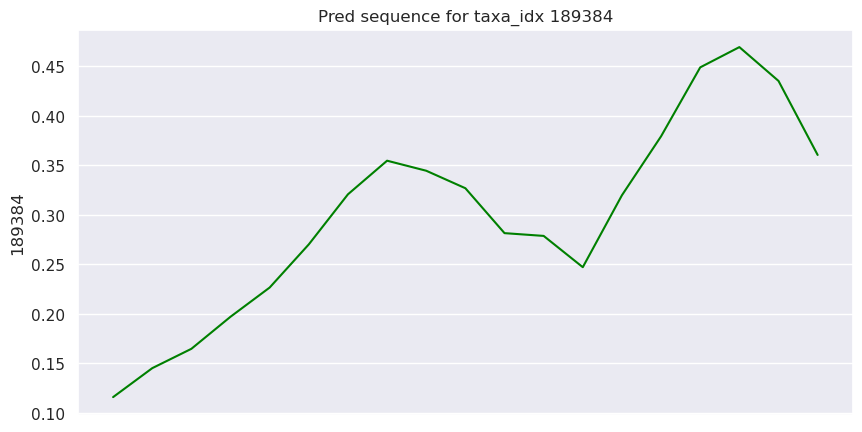

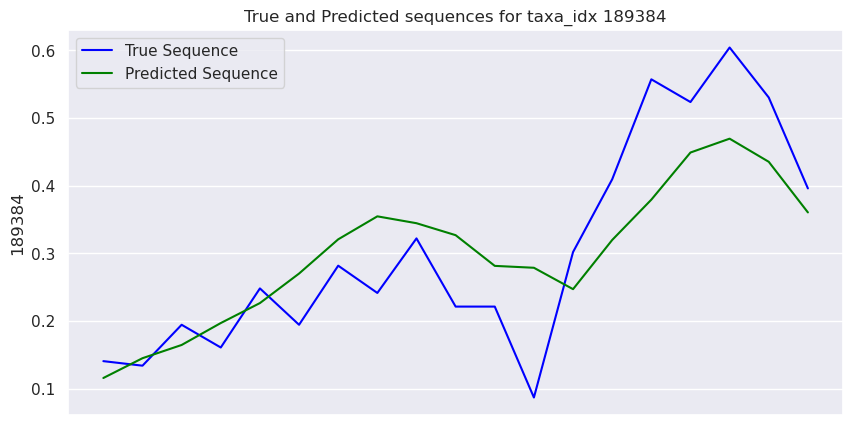

In [62]:
target_taxa = 189384

true_sequence = target_subject_y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = target_subject_y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [63]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols_true = df.columns[df.columns != "subject_id"]
    cols_pred = df.columns[~df.columns.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]
    
    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols_true
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols_pred
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [64]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model_ensemble, df, target_subject_idx, test_feats, test_targets)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

Predicting values: 100%|██████████| 202/202 [00:08<00:00, 22.83it/s]


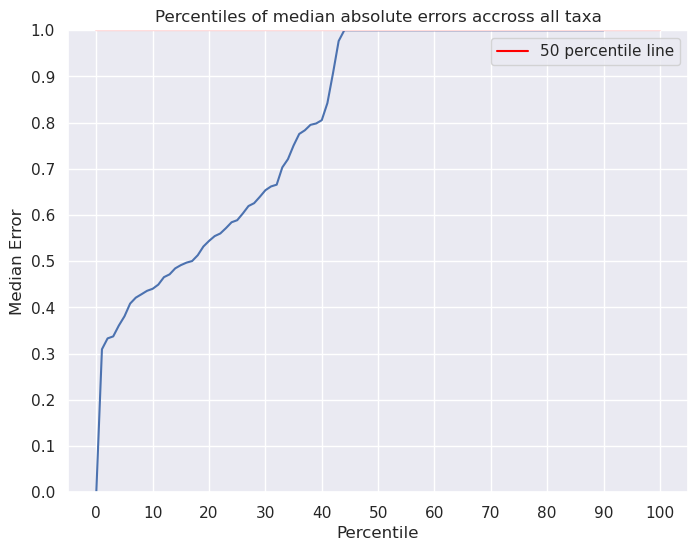

In [65]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=1)

In [66]:
only_predicted_taxa = test_subject_y_pred_df.columns[~(test_subject_y_pred_df.columns.isin(non_predicted_taxa))]
only_predicted_errors = errors_df[only_predicted_taxa]
only_predicted_errors.describe()

,3439402,4473763,175535,3887769,189384,4339832,309391,844375,3154070,509416,...,177567,367433,193484,577170,359650,130663,3304236,193233,583117,354850
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
unique,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,53.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,55.000000,56.000000,56.000000,56.000000,56.000000
top,1.000000,0.204322,92770606.279373,1.012954,0.176637,0.238083,0.512014,1.000000,1.000000,0.183141,...,0.910247,0.000000,0.584254,0.920456,0.310621,1.000000,1589252799.749374,6.531703,0.858171,0.498689
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


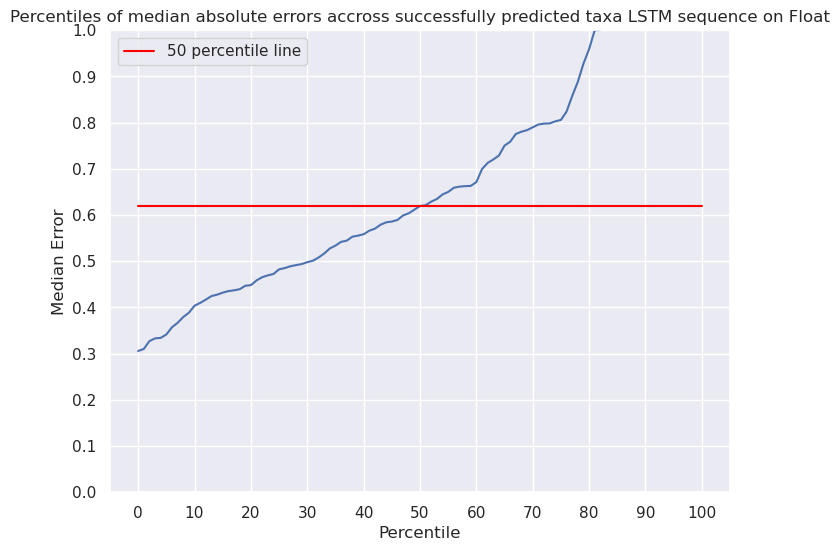

In [93]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)

In [ ]:
median_errors_plot(only_predicted_errors, clip=1)

In [ ]:
population_rates = calculate_non_zero_value_percentages(df).drop(['subject_id', 'sampling_day'])

What are the average population rates in the taxa that are predicted by this model compared to the ones that arent?

In [ ]:
population_rates[non_predicted_taxa].mean()

In [ ]:
population_rates[only_predicted_taxa].mean()

Among the predicted taxa, is the median error somehow related to the population rate?

In [ ]:
median_errors_by_population_rate(df, only_predicted_errors, only_predicted_taxa)